### Imports

In [2]:
import arcgis
from arcgis.gis import GIS
from ipywidgets import Layout
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model, model_from_json
from keras import optimizers, regularizers, models, layers
import requests
from io import BytesIO
from urllib.parse import urlencode
from os import listdir, remove, mkdir
from os.path import join, exists, expanduser, isdir
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from file_utils import make_dir_helper, is_jpeg, delete_dir_helper, delete_dir_files_helper
import numpy as np
from arcgis.geometry import Envelope
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
arcgis.__version__

'1.2.0'

### Path Constants

In [4]:
PROJECT_DIR = join(expanduser('~'),'desktop','Esri Project');
MAP_NAME = 'map.jpg'
TEMP_DIR = join(PROJECT_DIR, 'temp data')
TEMP_SLICED_DIR = join(TEMP_DIR, 'temp sliced')
TEMP_SLICED_SUBDIR = join(TEMP_SLICED_DIR, 'map sliced')
DATA_DIR = join(PROJECT_DIR, 'datasets', 'redlands dataset')
MODEL_DIR =  join(expanduser('~'),  PROJECT_DIR, 'models');
OUTPUT_DIR = join(PROJECT_DIR, 'outputs')

make_dir_helper(TEMP_DIR)
make_dir_helper(TEMP_SLICED_DIR)
make_dir_helper(TEMP_SLICED_SUBDIR)

True

In [4]:
classes = [dname for dname in listdir(DATA_DIR) if isdir(join(DATA_DIR, dname))]

### Slice Constants

In [8]:
SLICE_WIDTH, SLICE_HEIGHT = 256, 256
MAP_WIDTH, MAP_HEIGHT = 4096, 4096

In [9]:
gis = GIS()
arc_map = gis.map('San francisco')

arc_map.basemap = 'satellite'
arc_map

### Download map using the current extent

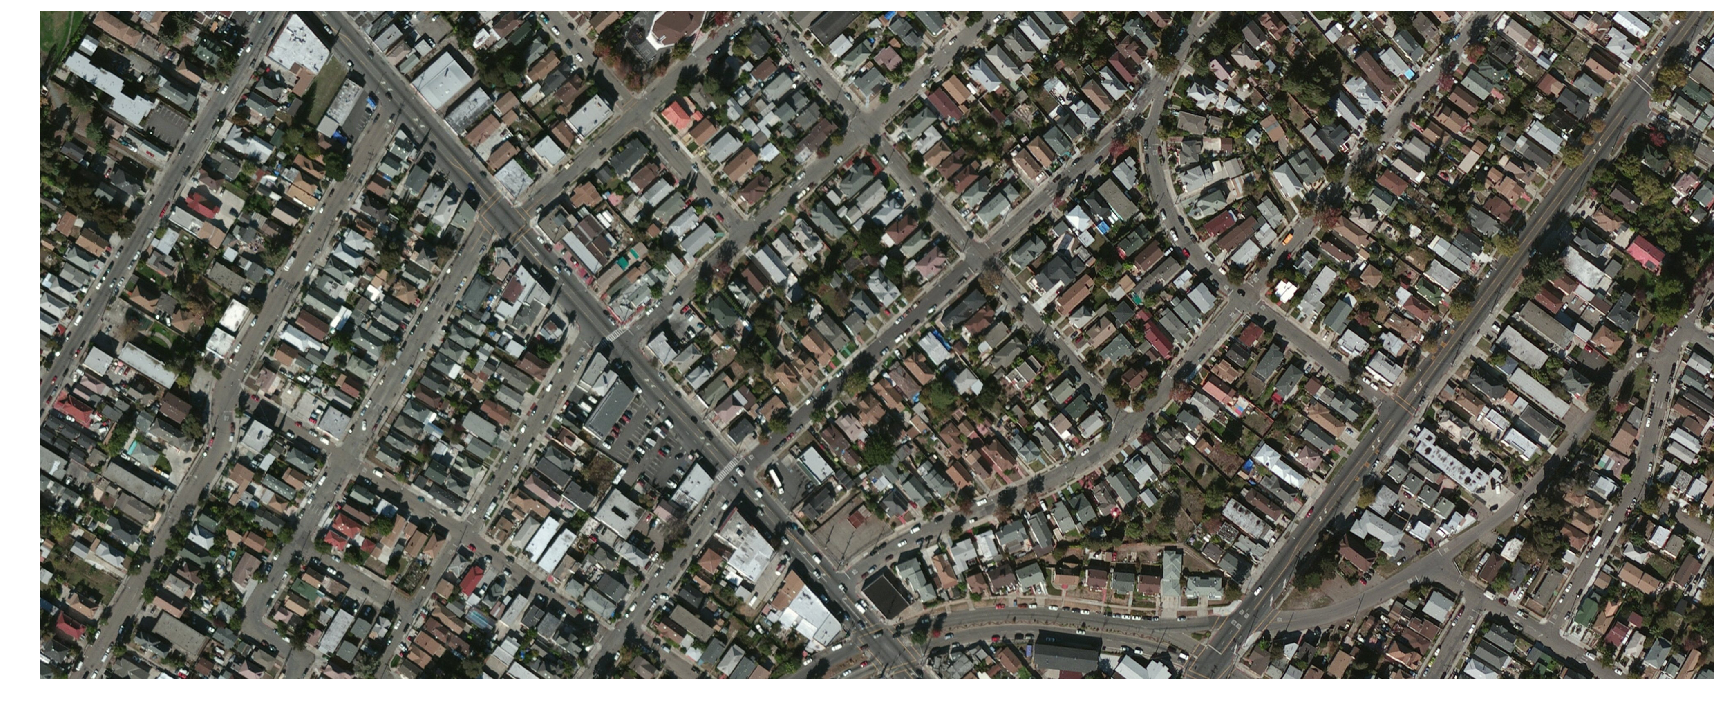

In [12]:
URL = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?'
extent = arc_map.extent

y_delta = (extent['ymax'] - extent['ymin'])
x_delta = (extent['xmax'] - extent['xmin'])

MAP_HEIGHT = round(MAP_WIDTH * y_delta /  x_delta)

parameters = {
    'bbox':'{},{},{},{}'.format(extent['xmin'], extent['ymin'], extent['xmax'], extent['ymax']),
    'bboxSR':extent['spatialReference']['latestWkid'],
    'size':'{},{}'.format(MAP_WIDTH, MAP_HEIGHT),
    'format':'jpg',
    'f':'image'
}

URL += urlencode(parameters)

MAP_FILE_PATH = join(TEMP_DIR, MAP_NAME)

if urlretrieve(URL, MAP_FILE_PATH):
    
    img = image.load_img(MAP_FILE_PATH, target_size=(MAP_HEIGHT, MAP_WIDTH)) 
    plt.figure(figsize=(30, 30)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Slice map into tiles and save in disk

In [13]:
with Image.open(MAP_FILE_PATH) as im:
    imgwidth, imgheight = im.size
    SLICE_WIDTH, SLICE_HEIGHT = 256, 256
    idx = 0
    start_idx = 14000
    delete_dir_files_helper(TEMP_SLICED_SUBDIR)
    
    for i in range(0, imgheight - SLICE_HEIGHT, SLICE_HEIGHT  // 2):
        for j in range(0, imgwidth - SLICE_WIDTH, SLICE_WIDTH  // 2):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                cropped_image = im.crop(box)
                cropped_image.save(join(TEMP_SLICED_SUBDIR, 'image_{}.jpg'.format(start_idx + idx)), "JPEG", quality=100, optimize=True)
                idx += 1
            except:
                traceback.print_exc()
                
                pass
    print('Saved ' + str(idx) + ' slices in ' + TEMP_SLICED_SUBDIR)

Saved 330 slices in C:\Users\thom8982\desktop\Esri Project\temp data\temp sliced\map sliced


def predict_class_overlay(img, model):
    
    img_resized = img.resize((128,128), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img_resized)
    img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
    img_tensor /= 255.
    predictions = model.predict(img_tensor)[0]
    max_val = np.amax(predictions)
    max_index = np.argmax(predictions)
    if max_val < 0.8:
        print('low accuracy for ' + str(max_index))
    
    return overlay_color_options[max_index]


with Image.open(MAP_FILE_PATH) as im:
    
    imgwidth, imgheight = im.size
    imgwidth, imgheight = imgwidth //2, imgheight // 2
    SLICE_WIDTH, SLICE_HEIGHT = 256, 256
    modified_image = Image.new('RGB', (imgwidth, imgheight))
    idx = 0
    y_offset = 0
    model = load_model(MODEL_PATH)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
    
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                 
                cropped_image = im.crop(box)
                overlay_color = predict_class_overlay(cropped_image, model)
              
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)
                cropped_image.paste(overlay, (0, 0), overlay)
                # cropped_image.save(join(TEMP_SLICED_DIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)
                
                modified_image.paste(cropped_image, (x_offset, y_offset))
                x_offset = x_offset + SLICE_WIDTH
                
            except:
                traceback.print_exc()
                pass
            idx +=1
        y_offset = y_offset + SLICE_HEIGHT
    modified_image.save(join(MAP_DIR, 'modified_map_2.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()

### Predict classification for multilabel classification tasks

In [ ]:
overlay_color_options = {
           0 : (0, 255, 0, 100),
           1 : (0, 255, 0, 100),
           2 : (0, 255, 255, 100),
           3 : (255, 255, 0, 100),
           4 : (0, 0, 0, 100),
           5 : (0, 0, 255, 100),
}


def predict_class_overlay(img, model):
    
    max_val = np.amax(predictions)
    max_index = np.argmax(predictions)
    if max_val < 0.8:
        print('low accuracy for ' + str(max_index))
    
    return overlay_color_options[max_index]


with Image.open(MAP_FILE_PATH) as map_image:
    
    MODEL_PATH =  join(MODEL_DIR, 'map_multi_model_redlands_2.h5');
    BATCH_SIZE = 10
    IMAGE_SIZE = 128
    
    imgwidth, imgheight = map_image.size
    idx = 0
    
    model = load_model(MODEL_PATH)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        TEMP_SLICED_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        save_format='jpeg',
        shuffle=False,
        class_mode=None)

    predictions = model.predict_generator(test_generator, 40, max_queue_size=10, workers=8, use_multiprocessing=False, verbose=0)

  
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                
                overlay_color = predict_class_overlay(predictions[idx])
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)  
                map_image.paste(overlay, (j, i), overlay)
            except:
                traceback.print_exc()
                pass
            idx +=1
      
    map_image.save(join(OUTPUT_DIR, 'map_detector_output.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(map_image)
    plt.axis('off')
    plt.show()

Found 330 images belonging to 1 classes.


### Predict slices for binary classification tasks

In [ ]:
def predict_class_overlay(prediction):
    
    if prediction > 0.4:
        return (0, 255, 0, 100)
    else:
        return (0, 255, 0, 0)



with Image.open(MAP_FILE_PATH) as map_image:
    
    MODEL_PATH =  join(MODEL_DIR, 'roads_model_road_detector.h5');
    
    imgwidth, imgheight = map_image.size
    idx = 0
    
    model = load_model(MODEL_PATH)
    model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
    BATCH_SIZE = 10

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        TEMP_SLICED_DIR,
        target_size=(SLICE_WIDTH, SLICE_HEIGHT),
        batch_size=BATCH_SIZE,
        save_format='jpeg',
        shuffle=False,
        class_mode=None)

    predictions = model.predict_generator(test_generator, 40, max_queue_size=10, workers=8, use_multiprocessing=False, verbose=0)
    predictions = np.asarray(predictions).flatten()
  
    for i in range(0, imgheight , SLICE_HEIGHT):
        x_offset = 0
        for j in range(0, imgwidth , SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                
                overlay_color = predict_class_overlay(predictions[idx])
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)  
                map_image.paste(overlay, (j, i), overlay)
            except:
                traceback.print_exc()
                pass
            idx +=1
      
    map_image.save(join(OUTPUT_DIR, 'road_detector_output.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(map_image)
    plt.axis('off')
    plt.show()